# Exercise: probabilistic neural networks

In this assignment you will first investigate a simple regression model, and then you will use an autoencoder to learn the structure of the MNIST dataset.

**What to submit.**
Your answers should contain an explanation of what you do, and
2&ndash;4 central commands to achieve it. 
The focus of your answer should be
_interpretation:_ explain what the numerical values and graphs
you produce _mean,_ and why they are as they are.  The text of
your answer to each question should be no more than a paragraph or
two. Marks will be awarded based on the clarity and insight in your explanations.

DO NOT SUBMIT FULL SOURCE CODE, unless it is as an appendix. Do not repeat the question text in your answers. If you submit your answers as a Jupyter notebook, structure the notebook in two sections: a section at the top for the examiner to read with just your answers and trimmed code snippets, and a section at the bottom with all your working code.

**What to optimize.**
This coursework is about the probabilistic interpretation of neural networks, not 
about neural network design.
The networks described here can be trained reasonably well in ten minutes on a low-end laptop. 
(Also see the appendix for how to load and save your models.)
You don't need to optimize your neural network designs, you don't need to run cross-validation for hyperparameters, and you don't need to implement early-stopping etc.

# DATASETS

Questions (a) and (b) use the xkcd dataset. Each datapoint is a pair $(x,y)$ of real numbers.

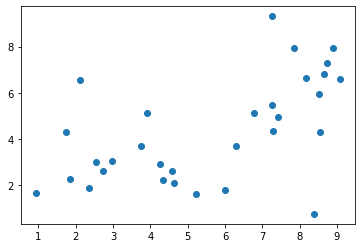

In [6]:
import pandas
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/xkcd.csv'
xkcd = pandas.read_csv(url)

import matplotlib.pyplot as plt
plt.scatter(xkcd.x, xkcd.y)

Questions (c)&ndash;(f) use the MNIST dataset. This can be obtained with the Python package `torchvision`. Each datapoint is a pair `[numpy_array, int]` representing images and labels.

Very many PyTorch building blocks assume that the data comes in batches.
The `DataLoader` converts the full mnist list `[(img,lbl),...]` into batches
`[(img_batch,lbl_batch), ...]`
where each `img_batch` is an array with an extra dimension prepended.

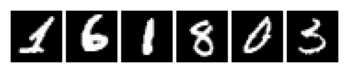

In [8]:
import torchvision

mnist = torchvision.datasets.MNIST(
    root = 'pytorch-data/',  # where to put the files
    download = True,         # if files aren't here, download them
    train = True,            # whether to import the test or the train subset
    # PyTorch uses PyTorch tensors internally, not numpy arrays, so convert them.
    transform = torchvision.transforms.ToTensor()
)


# Images can be plotted with matplotlib imshow
import torch
import matplotlib.pyplot as plt
show = [mnist[i] for i in [59289, 28001, 35508, 43876, 23627, 14028]]
show = torch.stack([img for img,lbl in show])
x = torchvision.utils.make_grid(show, nrow=6, pad_value=1)
plt.imshow(x.numpy().transpose((1,2,0)))
plt.axis('off')
plt.show()

mnist_batched = torch.utils.data.DataLoader(mnist, batch_size=100)

# QUESTIONS

## Question (a)

* The `RWiggle` class in the appendix describes the model $Y_i\sim N(f(x_i),\sigma^2)$. Fit it to the xkcd dataset. Display your fitted model as a ribbon plot, i.e. plot $f(x)$ and also the range $f(x)\pm1.96\sigma$ as a function of $x$. (Matplotlib offers `fill_between` for this type of plot.)

* Modify the model to allow $\sigma$ to depend on $x$; you can simply re-use the `Wiggle` class to express this dependency.   Display your fitted model as a ribbon plot. (A model with varying $\sigma$ is called a *heteroscedastic model*.)

## Question (b)

I find that my fitted heteroscedastic model achieves a higher training log likelihood than the `RWiggle model`, but I also observe that during the course of training its log likelihood frequently dips much lower.

* What would be the maximum possible training log likelihood for each of these two models, if the `f` function were rich enough?
* Plot a graph of training log likelihood as a function of epoch, for both of the models. Explain why I saw dips in the log likelihood for the heteroscedastic model.

## Question (c)

In the appendix is code for the autoencoder described in lecture notes. The generator is for Bernoulli images, and the encoder is Gaussian. Train it on MNIST images.

* For images `[59289, 28001, 35508, 43876]`, show the image, together with a sample of three reconstructed images from each of them.

* To image 35508, add noise in varying amounts, and show the reconstructed image.

* Generate 12 random images, and show them.

* Take two images, 28001 and 43876. Create a sequence of images that interpolates between these two, using simple linear interpolation in the latent space.

## Question (d)

Modify the autoencoder code so that it uses 100 samples for Monte Carlo approximation. (This isn't helpful for training, but it's a good idea if we want to actually know the log likelihood of a particular datapoint.)

Show some likely and some unlikely images. Can you identify any features that make an image likely or unlikely?

## Question (e)

The autoencoder in the appendix defaults to using 4 dimensions for the latent space. Train another version with 20 dimensions. Evaluate them. Explain carefully your grounds for comparison.

_Don't worry about making a "fair comparison" in the sense of e.g. putting in equal training effort; simply train for a fixed number of epochs, and treat the resulting neural networks as given. The focus of your answer should be on evaluation metrics._

**Optional.** Also compare to the [PyTorch example autoencoder](https://github.com/pytorch/examples/blob/master/vae/main.py).

## Question (f)

Consider the generative model $X=f(Z,y)$ where $y\in\{0,1,\dots,9\}$ is the image label, and $Z$ is a latent random variable. The hope is that $Z$ should capture the "style" of the digit: thus we could generate a stylistically similar set of digits by fixing $Z$ and varying $y$, or we could generate random samples of a single digit by fixing $y$ and varying $Z$.

* Given $x$ and $Y=y$, what is the perfect sampling distribution $\tilde{Z}$?

* Design an autoencoder for this generative model, and implement it, and train it. Illustrate its output by showing four different stylistically-similar sets of digits.

# Appendix

### Wiggly line

In [ ]:
class Wiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(1,4),
            nn.LeakyReLU(),
            nn.Linear(4,20),
            nn.LeakyReLU(),
            nn.Linear(20,20),
            nn.LeakyReLU(),
            nn.Linear(20,1)
        )
    def forward(self, x):
        return self.f(x)
    
class RWiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.μ = Wiggle()
        self.σpre = nn.Parameter(torch.tensor(1.0))
    @property
    def σ(self):
         return torch.nn.functional.softplus(self.σpre)
    def forward(self, y, x):
        σ2 = torch.pow(self.σ, 2)
        return - 0.5*torch.log(2*np.pi*σ2) - torch.pow(y - self.μ(x), 2) / (2*σ2)

### Autoencoder

In [ ]:
class BernoulliImageGenerator(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
        xr = self(z)
        return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1,2,3))


class GaussianEncoder(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:,:self.d], μτ[:,self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
        ε = torch.randn_like(σ)
        ll = self.f.loglik(x, z=μ+σ*ε)
        return ll - kl

### Interactive training

You may find it helpful to save and load trained models:
```python
torch.save(mymodel.state_dict(), 'filename.pt')

mymodel = MyModel()
mymodel.load_state_dict(torch.load('filename.pt'))
```

I find it helpful to be train, interrupt, inspect, resume training. For this purpose, I set up the model and the data cycler in one cell
```python
mymodel = ...
iter_mnist = enumerate_cycle(mnist_batched, shuffle=False)
```
and I do the optimization in a second cell
```python
optimizer = optim.Adam(mymodel.parameters())
with Interruptable() as check_interrupted:
    for (epoch,batch_num),(imgs,lbls) in iter_mnist:
        check_interrupted()
        ... # optimization step
```
This way I can interrupt (Kernel | Interrupt), inspect the state, and resume, and it will pick up exactly where it left off.

In [4]:
import signal
class Interruptable():
    class Breakout(Exception):
        pass
    def __init__(self):
        self.interrupted = False
        self.orig_handler = None
    def __enter__(self):
        self.orig_handler = signal.getsignal(signal.SIGINT)
        signal.signal(signal.SIGINT, self.handle)
        return self.check
    def __exit__(self, exc_type, exc_val, exc_tb):
        signal.signal(signal.SIGINT, self.orig_handler)
        if exc_type == Interruptable.Breakout:
            print(' stopped')
            return True
        return False
    def handle(self, signal, frame):
        if self.interrupted:
            self.orig_handler(signal, frame)
        print('Interrupting ...', end='')
        self.interrupted = True
    def check(self):
        if self.interrupted:
            raise Interruptable.Breakout
            
def enumerate_cycle(g, shuffle=True):
    epoch = 0
    while True:
        if shuffle:
            for i,j in enumerate(np.random.permutation(len(g))):
                yield (epoch,i), g[j]
        else:
            for i,x in enumerate(g):
                yield (epoch,i), x
        epoch = epoch + 1